# Coincap example

Crypto Currency Arbitrage Trading Back Testing within Coincap.

This document discribed how to get data from coincap to analyze arbitrage opportunity.

## 1. random get data from coincap

In [1]:
# get random data of Okex Binance Huobi Gate

import requests, time

binanceFile = open("../data/coincap_candles_m1_random/BTC/coincap_candles_binance_storj_m1_random.json","w+")
huobiFile = open("../data/coincap_candles_m1_random/BTC/coincap_candles_huobi_storj_m1_random.json","w+")

url = "https://api.coincap.io/v2/candles"

start = "2018-10-30 00:00:00, 0"
end = "2018-10-31 00:00:00, 0"

startTimeArray = time.strptime(start, "%Y-%m-%d %H:%M:%S, %f")
endTimeArray = time.strptime(end, "%Y-%m-%d %H:%M:%S, %f")
startTimeStamp = int(time.mktime(startTimeArray)*1000)
endTimeStamp = int(time.mktime(endTimeArray)*1000)

binanceQuerystring = {"exchange":"binance","interval":"m1","baseId":"storj","quoteId":"bitcoin",  
               "start":startTimeStamp,"end":endTimeStamp}
huobiQuerystring = {"exchange":"huobi","interval":"m1","baseId":"storj","quoteId":"bitcoin",  
               "start":startTimeStamp,"end":endTimeStamp}

binanceResponse = requests.request("GET", url, params=binanceQuerystring)
huobiResponse = requests.request("GET", url, params=huobiQuerystring)

binanceFile.write(binanceResponse.text)
huobiFile.write(huobiResponse.text)

binanceFile.close
huobiFile.close

<function TextIOWrapper.close()>

## 2.  read random data from coincap.json

In [2]:
# read random data of Okex Binance Huobi Gate
import talib
import datetime
import numpy as np
import pandas as pd
import mpl_finance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as dates

%matplotlib inline

binanceJsonFile = "../data/coincap_candles_m1_random/BTC/coincap_candles_binance_storj_m1_random.json"
huobiJsonFile = "../data/coincap_candles_m1_random/BTC/coincap_candles_huobi_storj_m1_random.json"

binanceJsonData = pd.read_json(binanceJsonFile,orient='values',encoding='utf-8').data
huobiJsonData = pd.read_json(huobiJsonFile,orient='values',encoding='utf-8').data

binanceQuotes = pd.DataFrame(columns=('period', 'open', 'high', 'low', 'close', 'volume'))
huobiQuotes = pd.DataFrame(columns=('period', 'open', 'high', 'low', 'close', 'volume'))

for index in range(len(binanceJsonData)):
    binanceQuotes.loc[index] = {'period':dates.date2num(datetime.datetime.fromtimestamp(float(binanceJsonData[index]['period'])/1000)),
                         'open':float(binanceJsonData[index]['open']), 'high':float(binanceJsonData[index]['high']), 'low':float(binanceJsonData[index]['low']),  
                        'close':float(binanceJsonData[index]['close']), 'volume':float(binanceJsonData[index]['volume'])}
for index in range(len(huobiJsonData)):
    huobiQuotes.loc[index] = {'period':dates.date2num(datetime.datetime.fromtimestamp(float(huobiJsonData[index]['period'])/1000)),
                         'open':float(huobiJsonData[index]['open']), 'high':float(huobiJsonData[index]['high']), 'low':float(huobiJsonData[index]['low']),  
                        'close':float(huobiJsonData[index]['close']), 'volume':float(huobiJsonData[index]['volume'])}

print("binance 1m data length:", len(binanceQuotes))
print("huobi 1m data length:", len(huobiQuotes))


binance 1m data length: 656
huobi 1m data length: 1416


# 3. analysis with biance and huobi

In [3]:
# huobi数据缺失严重，先处理数据

binanceQuotes.set_index(["period"], inplace=True)
huobiQuotes.set_index(["period"], inplace=True)

# get the intersection
ixs = binanceQuotes.index.intersection(huobiQuotes.index)

# check the intersection result
#for i in range(len(ixs)):
    #print(dates.num2date(ixs[i]).strftime("%Y-%m-%d %H:%M:%S"))

binanceSample = binanceQuotes.loc[ixs]
huobiSample = huobiQuotes.loc[ixs]

binanceSample.reset_index(drop=False, inplace=True)
huobiSample.reset_index(drop=False, inplace=True)

In [4]:
# 计算measurements
periods = ixs
measurements = pd.DataFrame(np.abs(binanceSample["close"] - huobiSample["close"])
                            - (binanceSample['close'] + huobiSample["close"]) * 0.001)
measurements.rename(columns={measurements.columns[0]:'dis'}, inplace = True)
#measurements = measurements.apply(lambda x: (x - np.mean(x)) / (np.std(x))) # normalization
#measurements = measurements.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

mu = np.mean(measurements['dis'])
sigma = np.std(measurements['dis'])

print("mu =", mu)
print("sigma =", sigma)

mu = 1.5268992248062215e-08
sigma = 8.250368047458642e-08


/home/paul/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

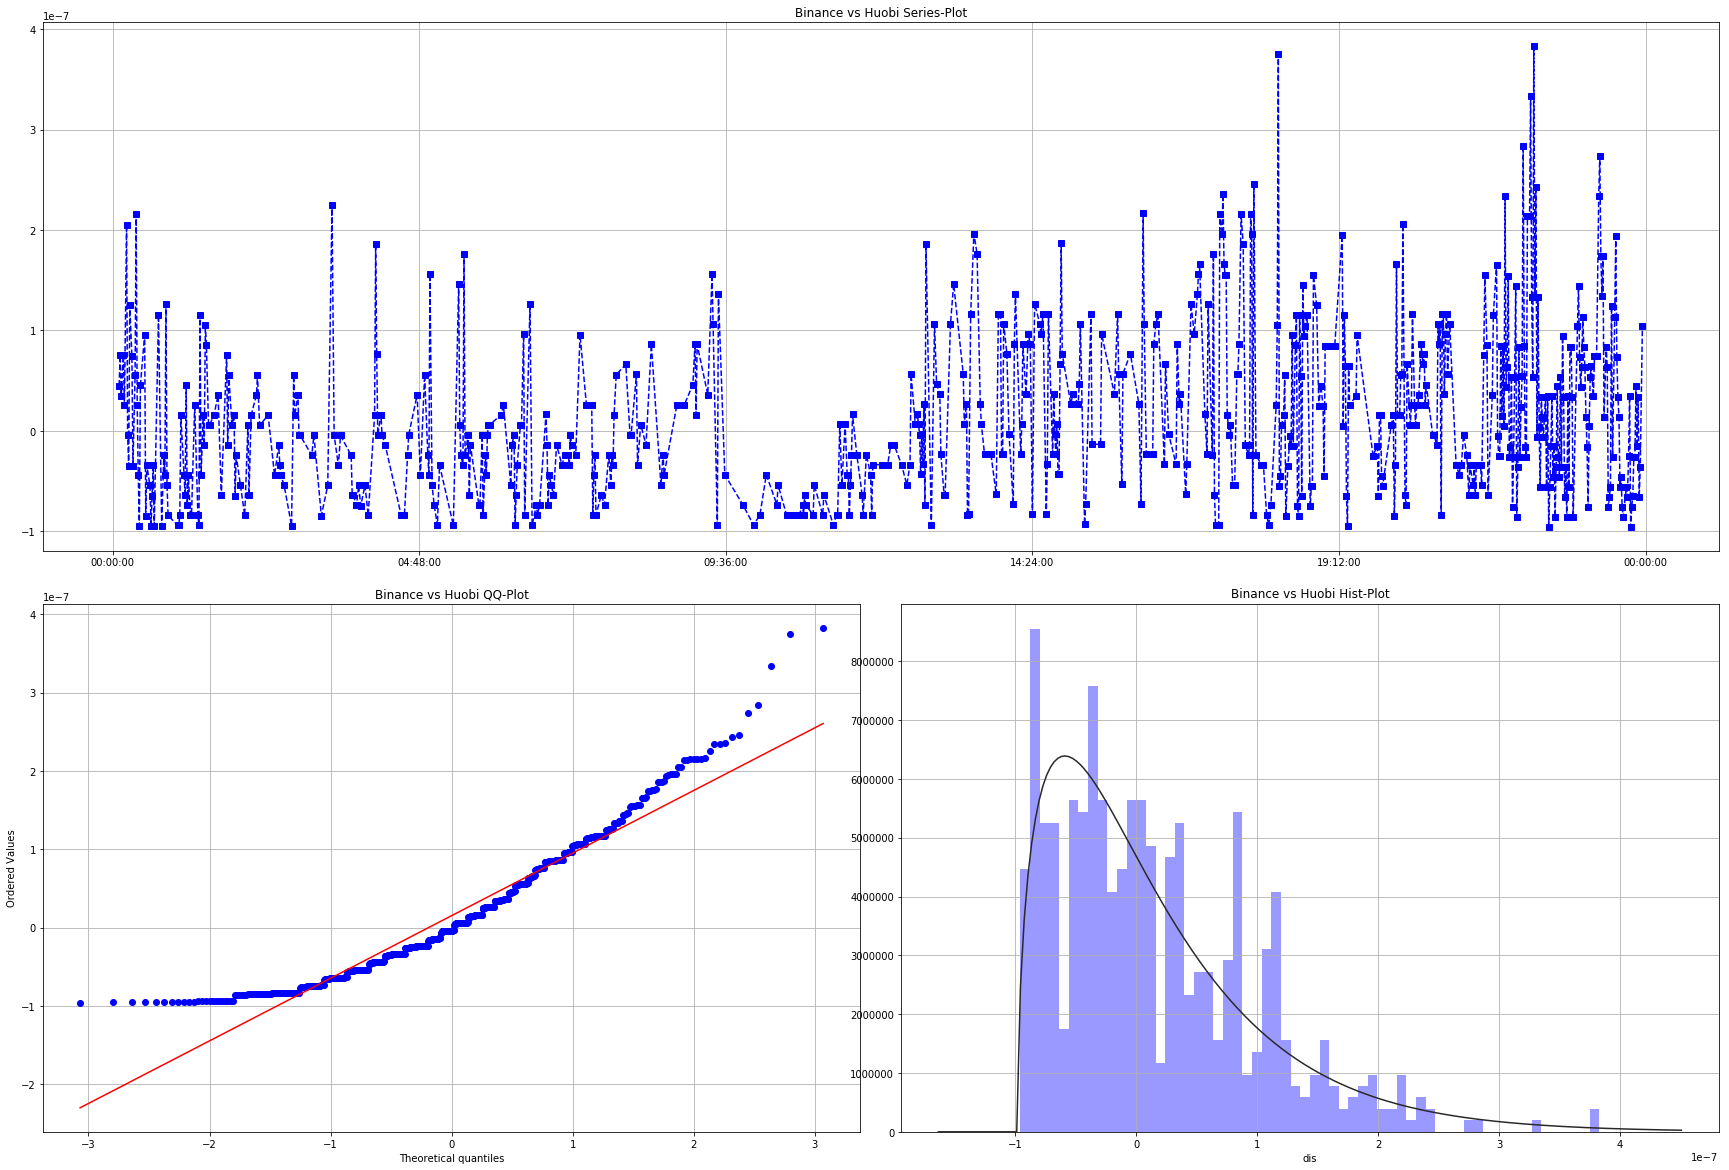

In [5]:
import matplotlib.dates as mdates
import pylab 
import scipy.stats as stats
import seaborn as sns

# draw basic info
plt.figure()
fig, axs = plt.subplots(2, 1, figsize=(24,16))
fig.tight_layout() #调整整体空白
plt.subplots_adjust(wspace =0.05, hspace =0.1) #调整子图间距

plt.subplot(2, 1, 1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.plot(periods, measurements, 'bs--',  label='hight-close')
plt.title("Binance vs Huobi Series-Plot")
plt.grid(True)

plt.subplot(2,2,3)
stats.probplot(measurements["dis"], dist="norm", plot=pylab)
plt.title("Binance vs Huobi QQ-Plot")
plt.grid(True)

plt.subplot(2,2,4)
sns.set_palette("hls") #设置所有图的颜色，使用hls色彩空间
sns.distplot(measurements["dis"],color="b",bins=60, fit=stats.gamma, kde=False)
plt.title("Binance vs Huobi Hist-Plot")
plt.grid(True)

plt.show()

## 4. back test with binance and huobi
### 各交易所交易手续费
okex: 0.1%； 
binance: 0.1%，用BNB 0.075%；
huobi: 0.2%；
gate: 0.2%。

0.9036000000000001